In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import lightgbm as lgb
import xgboost as xgb
from itertools import chain, combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('data/googleplay-train.csv')
df_test = pd.read_csv('data/googleplay-test.csv')

df_train.head(10)

,App,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Rating
0,"CBS Sports App - Scores, News, Stats & Watch Live",91031,Varies with device,"5,000,000+",Free,0,Everyone,Sports,4.3
1,Babbel – Learn Languages,266948,21M,"10,000,000+",Free,0,Everyone,Education,4.3
2,Feel Performer,62,34M,"10,000+",Free,0,Everyone,Communication,2.3
3,LG Hi-Fi Plus Manager,154,3.4M,"10,000+",Free,0,Everyone,Tools,3.4
4,Browser 4G,192948,6.6M,"10,000,000+",Free,0,Everyone,Communication,4.3
5,Google Ads,29313,20M,"5,000,000+",Free,0,Everyone,Business,4.4
6,"Q Alerts: QAnon Drop Notifications, Research +++",143,26M,"5,000+",Paid,$0.99,Mature 17+,News & Magazines,4.6
7,Fruit Ninja®,5091448,41M,"100,000,000+",Free,0,Everyone,Arcade,4.3
8,Air Transat CinePlus B,83,6.7M,"50,000+",Free,0,Everyone,Travel & Local,2.2
9,EU-Schwerbehinderung,3,32M,100+,Free,0,Everyone 10+,NaN,4.1


In [3]:
df_test.head(10)

,App,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,FP Markets,1,2.0M,100+,Free,0,Everyone,Finance
1,"Diabetes, Blood Pressure, Health Tracker App",309,5.9M,"10,000+",Free,0,Everyone,Medical
2,Frontback - Social Photos,19446,Varies with device,"1,000,000+",Free,0,Mature 17+,Social
3,e-DN - den digitala tidningen från Dagens Nyheter,160,32M,"50,000+",Free,0,Everyone 10+,News & Magazines
4,Roulette Advisor LITE,41,1.4M,"5,000+",Free,0,Everyone,Casino
5,LA Times: Your California News,3311,10M,"100,000+",Free,0,Everyone,News & Magazines
6,English Persian Dictionary,26875,73M,"500,000+",Free,0,Everyone,Books & Reference
7,NOOK: Read eBooks & Magazines,155446,Varies with device,"10,000,000+",Free,0,Teen,Books & Reference
8,BSC IT,847,21M,"10,000+",Free,0,Everyone,Education
9,HTC Speak,6145,13M,"10,000,000+",Free,0,Everyone,Lifestyle


In [4]:
df_train.dtypes

App                object
Reviews             int64
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Rating            float64
dtype: object

In [5]:
df_train['Content Rating'].value_counts()

Everyone           6298
Teen                848
Mature 17+          319
Everyone 10+        261
Unrated               1
Adults only 18+       1
Name: Content Rating, dtype: int64

In [6]:
df_test['Content Rating'].value_counts()

Everyone           1605
Teen                188
Mature 17+           74
Everyone 10+         61
Adults only 18+       2
Unrated               1
Name: Content Rating, dtype: int64

In [7]:
df_train.nunique()

App               7728
Reviews           4392
Size               406
Installs            21
Type                 2
Price               81
Content Rating       6
Genres             112
Rating              41
dtype: int64

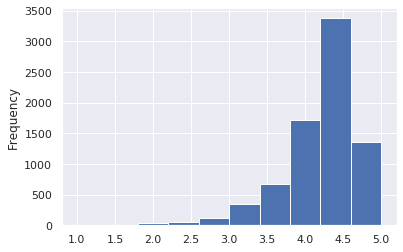

In [8]:
df_train['Rating'].plot(kind='hist');

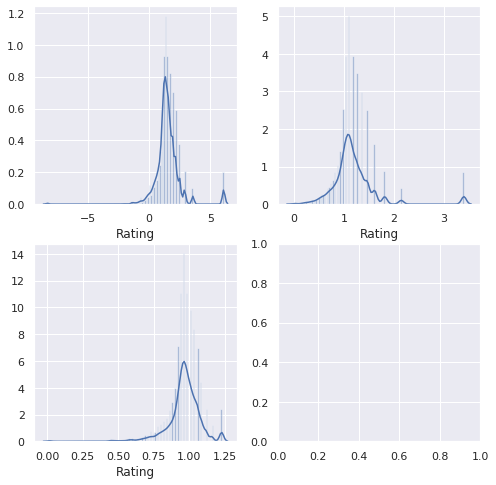

In [9]:
rating = (df_train.Rating - 0.999) / 4.01

trans_funcs = {'logit': lambda x: np.log(x/(1-x)) 
              ,'log1p1s': lambda x: 0.5 * np.log((1+x)/(1-x)) 
              ,'arcsin': lambda x: np.sqrt(np.arcsin(x))}

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, func in zip(axes.flat, ['logit', 'log1p1s', 'arcsin']):
    sns.distplot(trans_funcs[func](rating), kde=True, bins=120, ax=ax)
#    ax.hist(trans_funcs[func](rating), bins=20)

In [10]:
def fix_size(x):
    if 'M' in x:
        return float(x.strip('M'))
    else:
        return 5.

def cleandata(df, test=False):
    
    df.loc[df['Content Rating']=='Unrated', 'Content Rating'] = 'Everyone'
    df['Genres']=df['Genres'].fillna('OtherGenre')
    
    if test:
        df.loc[df['Genres']=='February 11, 2018', 'Genres'] = 'OtherGenre'
        df.loc[df['Installs']=='Free', 'Installs'] = '5000+'
        df.loc[df['Price']=='Everyone', 'Price'] = '$0'
        df.loc[df['Reviews'].str.contains('M'), 'Reviews'] =df.loc[df['Reviews'].str.contains('M'), 'Reviews'].str.replace('\\.0M', '000000')
        df['Reviews'] = df['Reviews'].astype(np.int64)
    else:
        df.loc[df['Genres'].str.contains('Music & Audio'), 'Genres'] = df.loc[df['Genres'].str.contains('Music & Audio'), 'Genres'].str.replace('Music & Audio', 'Music')
        
    df.loc[df['Genres'].str.contains('Educational'), 'Genres'] = df.loc[df['Genres'].str.contains('Educational'), 'Genres'].str.replace('Educational', 'Education')
    df['Size']=df['Size'].map(fix_size)
    df['Installs']=df['Installs'].str.replace('[+,]', '').astype(np.float64)
    df['Price']=df['Price'].str.strip('$').astype(np.float32)
    
    return df

df_train = cleandata(df_train)
df_test = cleandata(df_test, test=True)

In [11]:
def get_genres(series):
    
    genres_list = series.str.split(';')
    genres_all = list(chain.from_iterable(genres_list))
    
    return np.unique(genres_all)

genre_cates = get_genres(df_train['Genres'])

In [12]:
genre_cates

array(['Action', 'Action & Adventure', 'Adventure', 'Arcade',
       'Art & Design', 'Auto & Vehicles', 'Beauty', 'Board',
       'Books & Reference', 'Brain Games', 'Business', 'Card', 'Casino',
       'Casual', 'Comics', 'Communication', 'Creativity', 'Dating',
       'Education', 'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Maps & Navigation', 'Medical', 'Music',
       'Music & Video', 'News & Magazines', 'OtherGenre', 'Parenting',
       'Personalization', 'Photography', 'Pretend Play', 'Productivity',
       'Puzzle', 'Racing', 'Role Playing', 'Shopping', 'Simulation',
       'Social', 'Sports', 'Strategy', 'Tools', 'Travel & Local',
       'Trivia', 'Video Players & Editors', 'Weather', 'Word'],
      dtype='<U23')

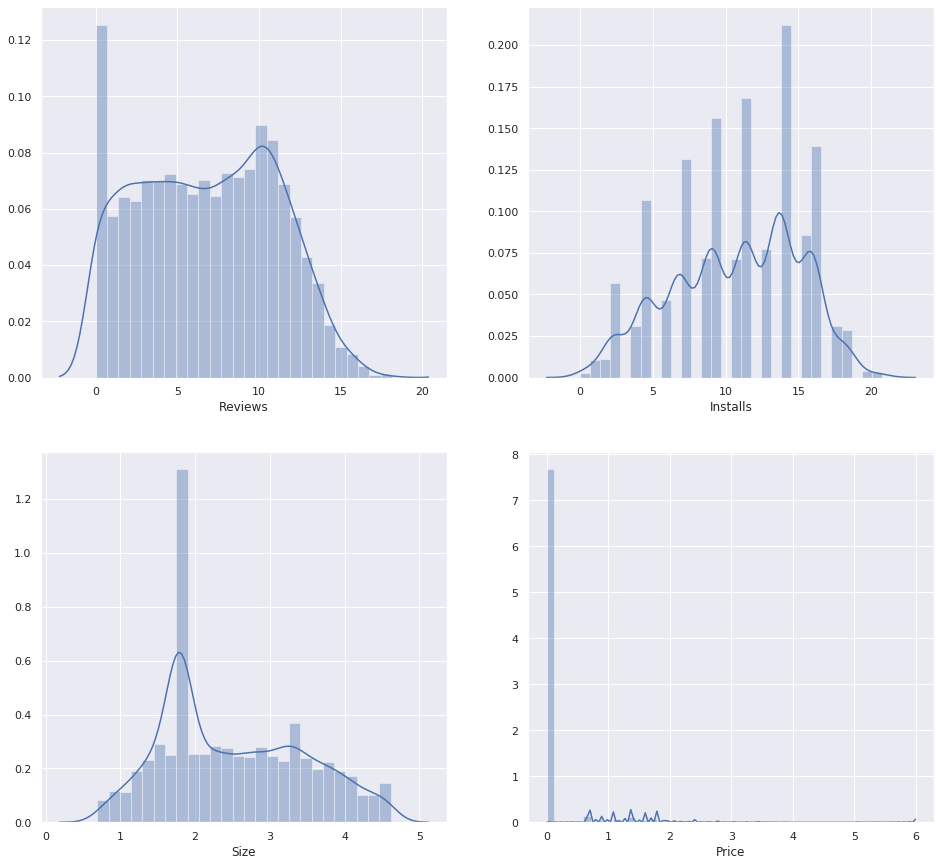

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 15))

for ax, name in zip(axes.flat, ['Reviews', 'Installs', 'Size', 'Price']):
    sns.distplot(np.log1p(df_train[name]), ax=ax)

In [14]:
df_all = pd.concat((df_train.drop('Rating', axis=1), df_test))

In [73]:
def preparedata(df, genres):
    
    df_output = np.log1p(df[['Reviews', 'Size', "Installs"]])
    for name in ['Reviews', 'Size', "Installs"]:
        df_output[name+'_squared'] = np.power(df_output[name], 2)
        
    for var1, var2 in combinations(['Reviews', 'Size', "Installs"], 2):
        df_output[var1 + '_' + var2] = df_output[var1] * df_output[var2]
        
    cont_vars =list(df_output.columns)
    df_temp = pd.DataFrame()
    
    for genre in genres:
        df_temp[genre] = pd.Series(df['Genres'].str.contains(genre), dtype=np.int32)
#        for cont_var in cont_vars:
#            df_output[cont_var + '_in_' + genre] = df_output[cont_var] * df_temp[genre]
        
    df_output['Type'] = pd.Series(df['Type']=='Free', dtype=np.int32)
    
    df_output = pd.concat((df_output, pd.get_dummies(df['Content Rating']), df_temp), axis=1)
    
    return df_output

df_all2 = preparedata(df_all, genre_cates)
feature_names = list(df_all2.columns)
df_all2.columns

Index(['Reviews', 'Size', 'Installs', 'Reviews_squared', 'Size_squared',
       'Installs_squared', 'Reviews_Size', 'Reviews_Installs', 'Size_Installs',
       'Type', 'Adults only 18+', 'Everyone', 'Everyone 10+', 'Mature 17+',
       'Teen', 'Action', 'Action & Adventure', 'Adventure', 'Arcade',
       'Art & Design', 'Auto & Vehicles', 'Beauty', 'Board',
       'Books & Reference', 'Brain Games', 'Business', 'Card', 'Casino',
       'Casual', 'Comics', 'Communication', 'Creativity', 'Dating',
       'Education', 'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo', 'Lifestyle',
       'Maps & Navigation', 'Medical', 'Music', 'Music & Video',
       'News & Magazines', 'OtherGenre', 'Parenting', 'Personalization',
       'Photography', 'Pretend Play', 'Productivity', 'Puzzle', 'Racing',
       'Role Playing', 'Shopping', 'Simulation', 'Social', 'Sports',
       'Strategy', 'Tools', 'Travel & Local', 'Trivia',
       'Vide

In [74]:
normalizer = StandardScaler()
X_left = normalizer.fit_transform(df_all2.iloc[:, :9].values)

In [75]:
X = np.hstack((X_left, df_all2.iloc[:, 9:])).astype(np.float32)
X_train, X_test = X[:len(df_train),:], X[len(df_train):,:]
Y_train = df_train['Rating'].values.astype(np.float32)

In [76]:
trans_funcs['identity'] = lambda x: x
trans_funcs['invidentity'] = lambda y: y
trans_funcs['norm'] = lambda x: (x - 0.999) / 4.01
trans_funcs['invnorm'] = lambda y: np.clip(y * 4.01 + 0.999, 1., 5.)
trans_funcs['invlogit'] = lambda y: 1 / (1 + np.exp(-y))
trans_funcs['invlog1pls'] = lambda y: (np.exp(2.*y) - 1)/(np.exp(2.*y) + 1)
trans_funcs['invarcsin'] = lambda y: np.sin(np.power(y, 2))

In [77]:
def cust_cv(mod, X, Y, dict_funcs, fun='identity'):
    Y_norm = dict_funcs['norm'](Y)
    Y_end = dict_funcs[fun](Y_norm)
    
    Y_pred = cross_val_predict(mod, X, Y, cv=10)
    
    Y_pred = dict_funcs['inv' + fun](Y_pred)
    Y_pred = dict_funcs['invnorm'](Y_pred)
    
    return np.sqrt(mean_squared_error(Y, Y_pred))

In [80]:
mod1 = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         num_leaves=255)

In [81]:
cust_cv(mod1, X_train, Y_train, dict_funcs=trans_funcs)

0.9693210811887996

In [71]:
mod2 = xgb.XGBRegressor(objective='reg:linear', learning_rate=0.1, max_depth=6, silent=True)

In [72]:
cust_cv(mod2, X_train, Y_train, dict_funcs=trans_funcs)

0.96932113